In [2]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.tree import DecisionTreeClassifier
#from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import scipy.stats as stats

# Using a sample of the data
Since the dataset is too large and contains more than 7 million rows, I have taken only 600k from them.

In [3]:

# Define the size of the sample
sample_size = 600000
chunk_size = 10000  # Adjust based on your system's memory capacity

# Initialize an empty list to store sampled rows
sampled_rows = []

# Iterate over the CSV file in chunks
for chunk in pd.read_csv('US_Accidents_March23 copy.csv', chunksize=chunk_size):
    # Randomly sample rows from the current chunk
    sampled_chunk = chunk.sample(n=min(sample_size, len(chunk)))
    sampled_rows.append(sampled_chunk)
    sample_size -= len(sampled_chunk)
    if sample_size <= 0:
        break

# Concatenate all sampled chunks into a single DataFrame
sampled_data = pd.concat(sampled_rows)

# Save the sampled data to a new CSV file
sampled_data.to_csv('data.csv', index=False)


In [4]:
df = pd.read_csv("data.csv")
df

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-6931,Source2,3,2016-12-13 09:44:58,2016-12-13 10:14:15,37.732540,-122.405090,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
1,A-8786,Source2,2,2016-12-27 23:47:02,2016-12-28 00:15:23,37.364971,-122.104691,NaN,NaN,0.00,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-9181,Source2,2,2016-12-31 15:59:40,2016-12-31 16:44:26,39.234276,-121.064934,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
3,A-2031,Source2,3,2016-07-04 03:24:22,2016-07-04 04:24:23,37.328423,-121.870827,NaN,NaN,0.00,...,False,False,False,False,False,False,Night,Night,Night,Night
4,A-4586,Source2,2,2016-07-28 16:45:19,2016-07-28 18:00:19,38.474407,-121.419067,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,A-602961,Source2,1,2022-06-06 05:06:07,2022-06-06 06:35:41,30.328831,-97.715828,NaN,NaN,0.00,...,False,True,False,False,True,False,Night,Night,Night,Day
599996,A-596350,Source2,3,2022-06-10 21:20:16,2022-06-10 22:23:50,33.864491,-118.326515,NaN,NaN,0.00,...,False,False,False,False,False,False,Night,Night,Night,Day
599997,A-605492,Source2,1,2022-05-31 04:03:54,2022-05-31 04:44:08,41.069981,-74.054092,NaN,NaN,0.00,...,False,False,False,False,False,False,Night,Night,Night,Day
599998,A-597460,Source2,1,2022-06-10 07:31:48,2022-06-10 08:31:36,34.726971,-82.388802,NaN,NaN,0.00,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     600000 non-null  object 
 1   Source                 600000 non-null  object 
 2   Severity               600000 non-null  int64  
 3   Start_Time             600000 non-null  object 
 4   End_Time               600000 non-null  object 
 5   Start_Lat              600000 non-null  float64
 6   Start_Lng              600000 non-null  float64
 7   End_Lat                0 non-null       float64
 8   End_Lng                0 non-null       float64
 9   Distance(mi)           600000 non-null  float64
 10  Description            600000 non-null  object 
 11  Street                 599102 non-null  object 
 12  City                   599978 non-null  object 
 13  County                 600000 non-null  object 
 14  State                  600000 non-nu

From this we notice that End_Lat & End_Lng columns have all null values and can be dropped

In [6]:
df.isnull().sum().sort_values(ascending=False)

End_Lat                  600000
End_Lng                  600000
Precipitation(in)        462056
Wind_Chill(F)            452455
Wind_Speed(mph)           93008
Visibility(mi)            12465
Weather_Condition         12004
Humidity(%)               10205
Temperature(F)             9331
Pressure(in)               7197
Wind_Direction             6180
Weather_Timestamp          5324
Street                      898
Nautical_Twilight           695
Civil_Twilight              695
Sunrise_Sunset              695
Astronomical_Twilight       695
Airport_Code                330
Timezone                    136
Zipcode                      66
City                         22
Junction                      0
Severity                      0
Start_Time                    0
End_Time                      0
Turning_Loop                  0
Traffic_Signal                0
Traffic_Calming               0
Stop                          0
Station                       0
Roundabout                    0
Railway 

# Getting a report of the dataset

In [7]:
# from ydata_profiling import ProfileReport
# prof = ProfileReport(df)
# prof.to_file(output_file='data.html')

## Handling datetime variables

In [8]:
# handle datetime variables
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

In [9]:
# extract Relevant Features
df['Start_Year'] = df['Start_Time'].dt.year
df['Start_Month'] = df['Start_Time'].dt.month
df['Start_Day'] = df['Start_Time'].dt.day
df['Start_Hour'] = df['Start_Time'].dt.hour
df['Start_Weekday'] = df['Start_Time'].dt.weekday  # Monday=0, Sunday=6
df['Is_Weekend'] = df['Start_Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Dropping unnecessary columns
From the ydata report, we have carefully identified and dropped columns that seem irrelevant to the prediction

In [10]:
drop_cols = ['ID' , 'Start_Time' , 'End_Time' , 'Description' , 'County', 'State' , 'Zipcode' , 'Country' , 'Timezone' , 'Airport_Code', 'End_Lat' , 'End_Lng' , 'Wind_Chill(F)' , 'Precipitation(in)', 'Street' , 'Astronomical_Twilight' , 'Sunrise_Sunset' , 'Civil_Twilight' , 'City','Nautical_Twilight', 'Weather_Timestamp']

df.drop(columns = drop_cols , inplace = True)

In [11]:
df.isnull().sum().sort_values(ascending=False)

Wind_Speed(mph)      93008
Visibility(mi)       12465
Weather_Condition    12004
Humidity(%)          10205
Temperature(F)        9331
Pressure(in)          7197
Wind_Direction        6180
Start_Year               0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Source                   0
Start_Month              0
Roundabout               0
Start_Day                0
Start_Hour               0
Start_Weekday            0
Station                  0
Give_Way                 0
Railway                  0
No_Exit                  0
Junction                 0
Severity                 0
Crossing                 0
Bump                     0
Amenity                  0
Distance(mi)             0
Start_Lng                0
Start_Lat                0
Is_Weekend               0
dtype: int64

# Checking the distrubution of classes in Severity column

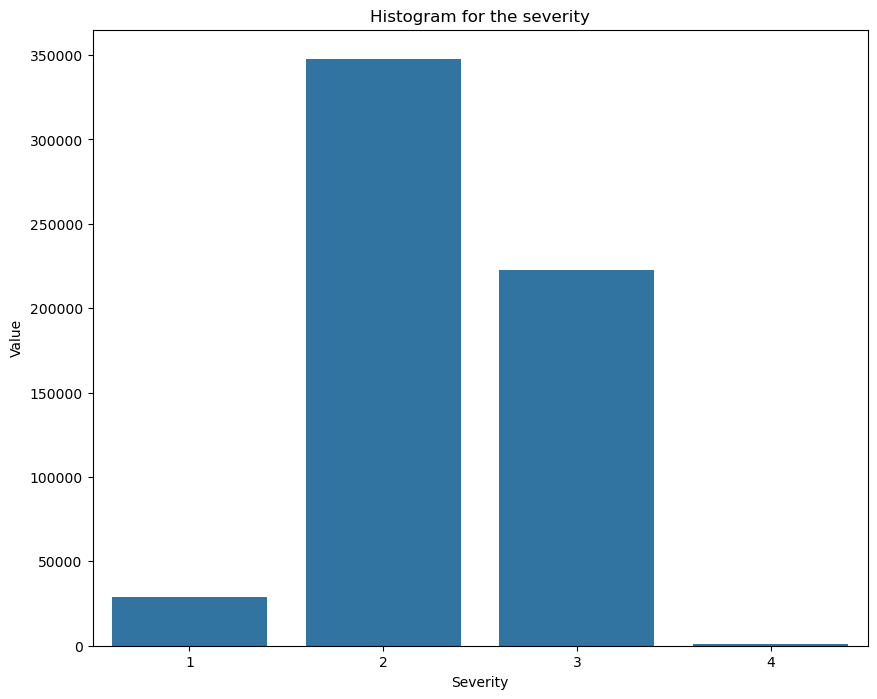

In [12]:
#check if the data is unbalenced
severity_counts = df["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

# Checking distribution of each column

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


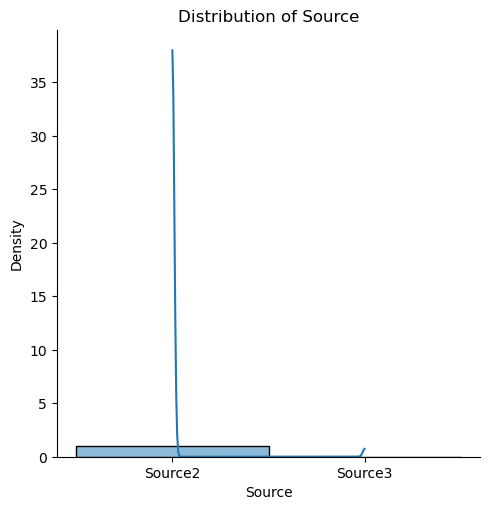

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


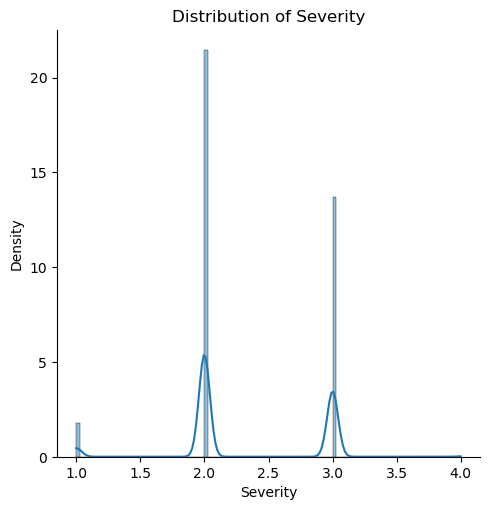

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


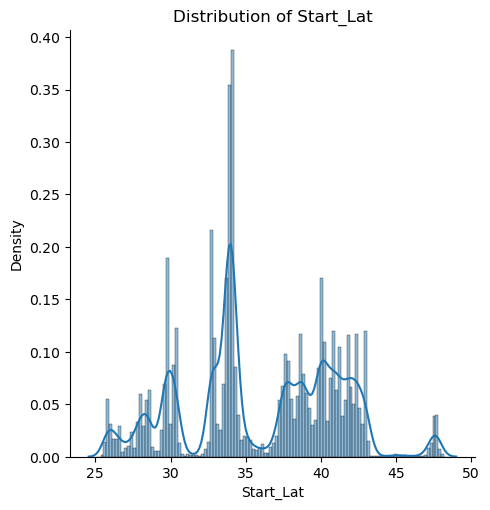

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


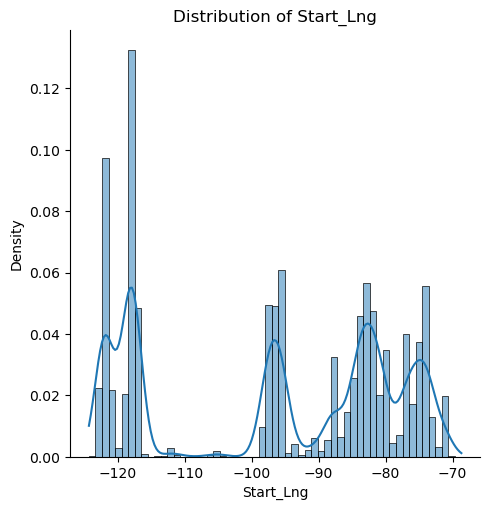

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


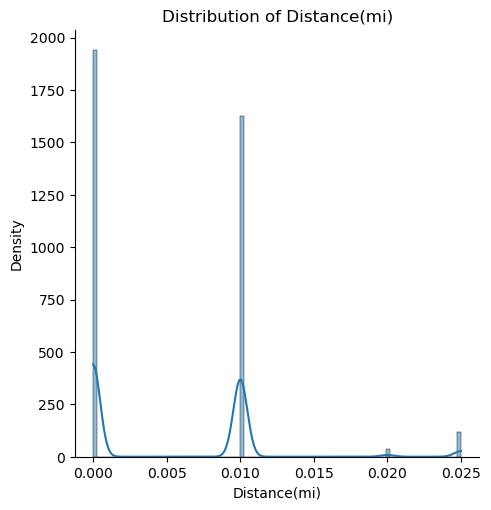

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


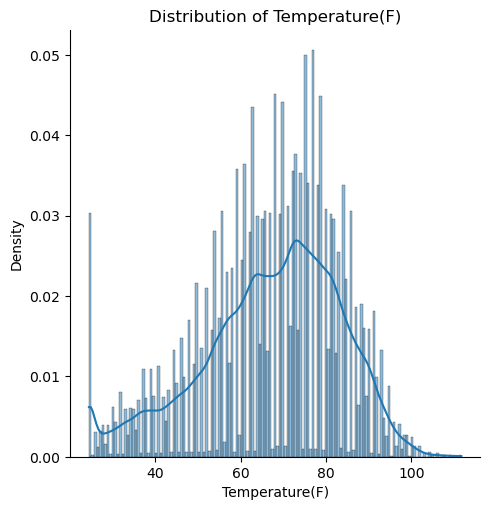

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


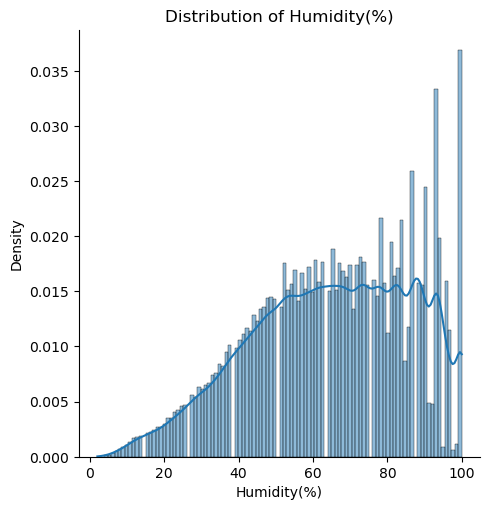

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


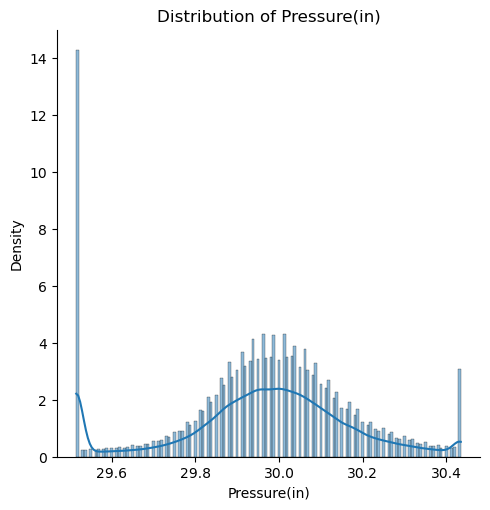

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


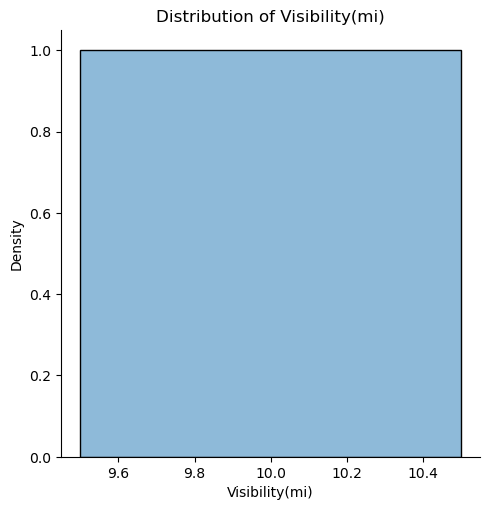

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


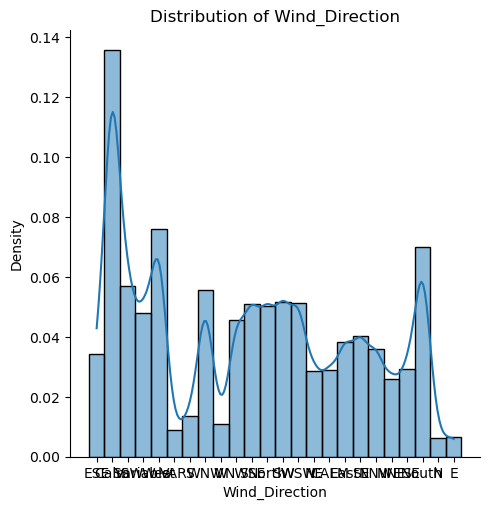

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


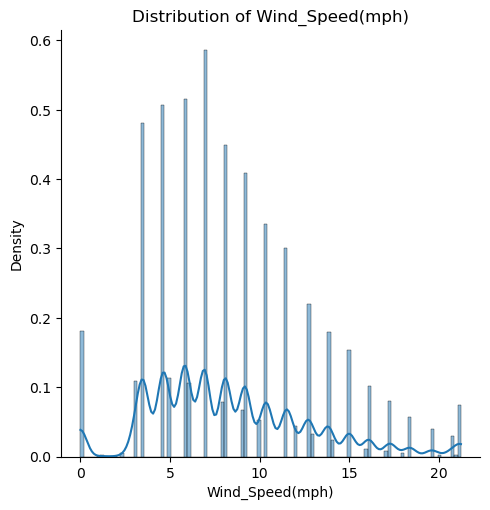

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


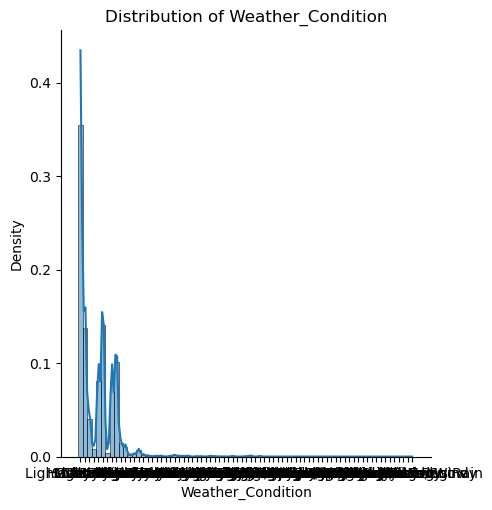

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


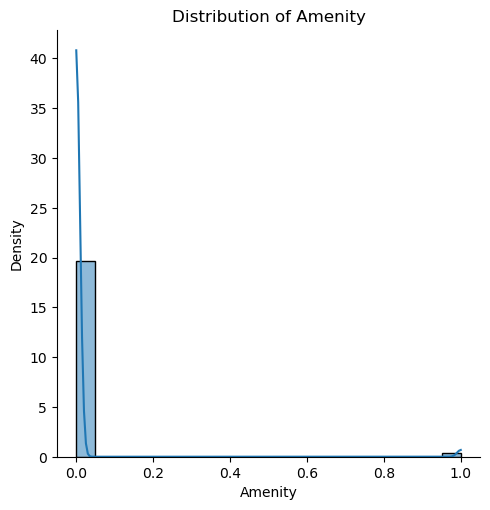

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


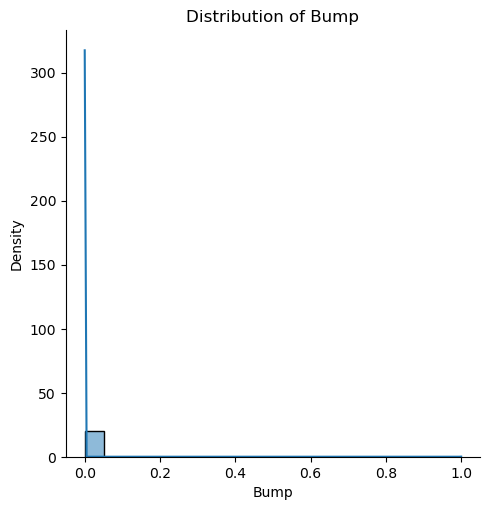

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


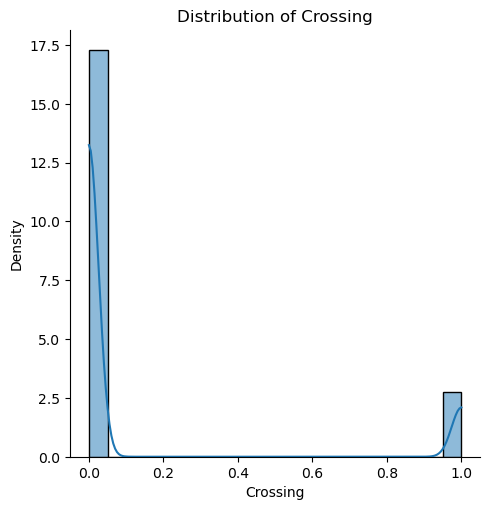

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


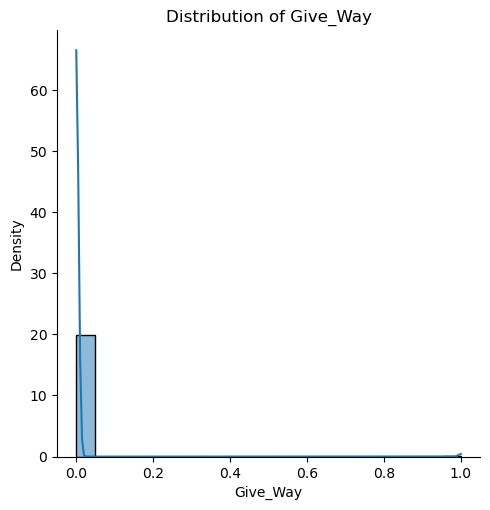

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


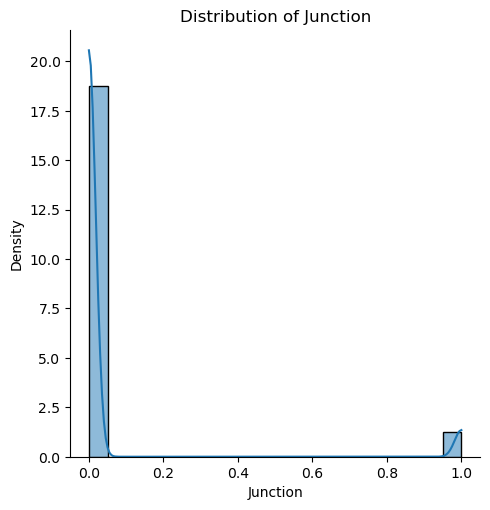

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


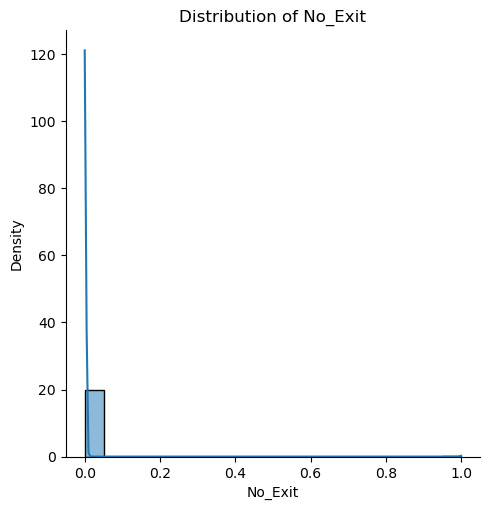

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


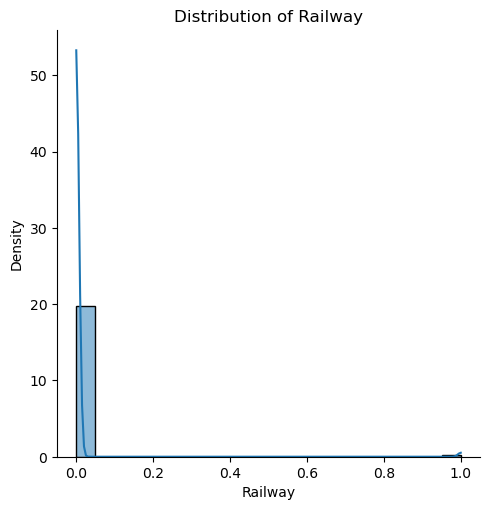

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


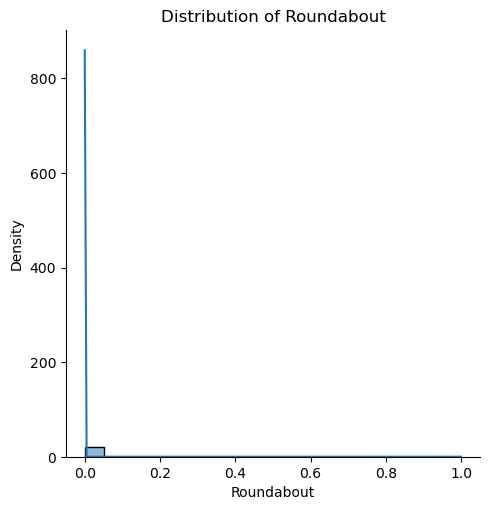

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


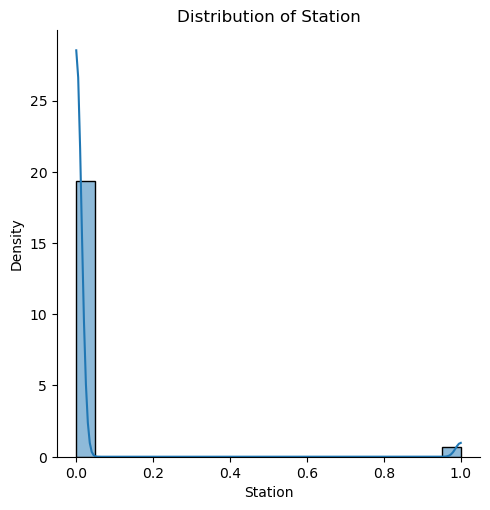

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


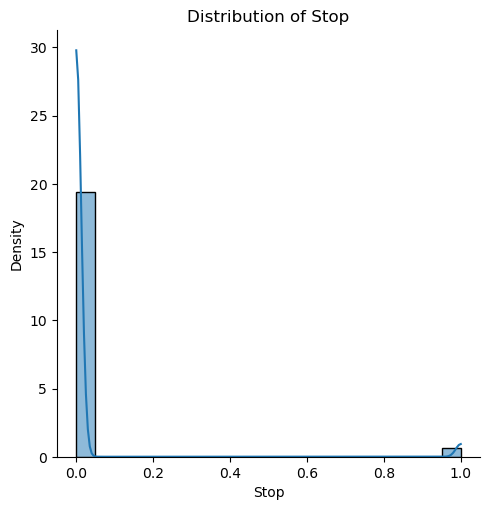

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


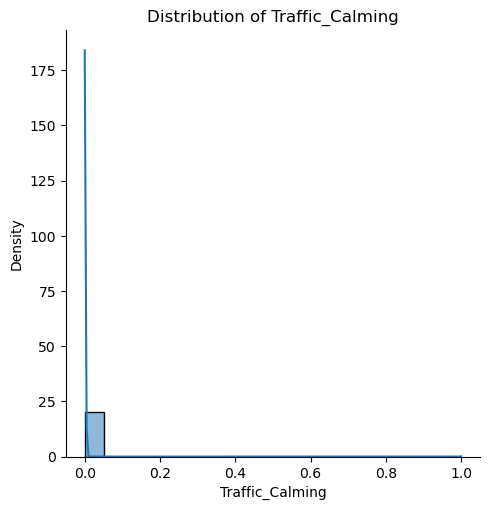

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


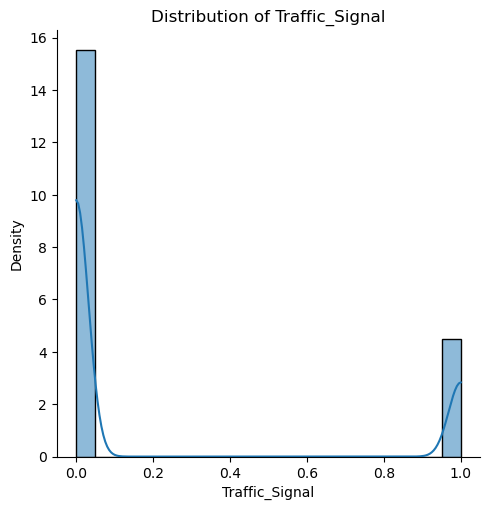

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


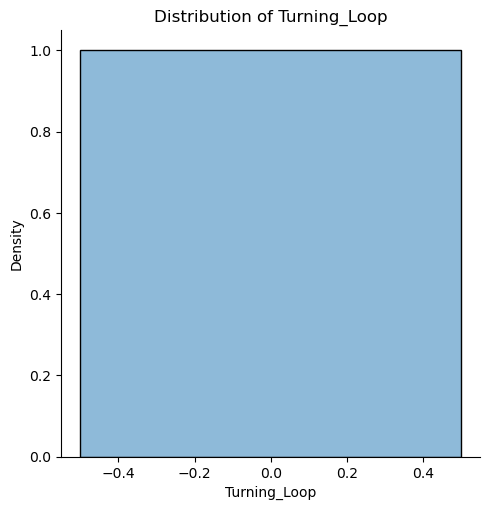

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


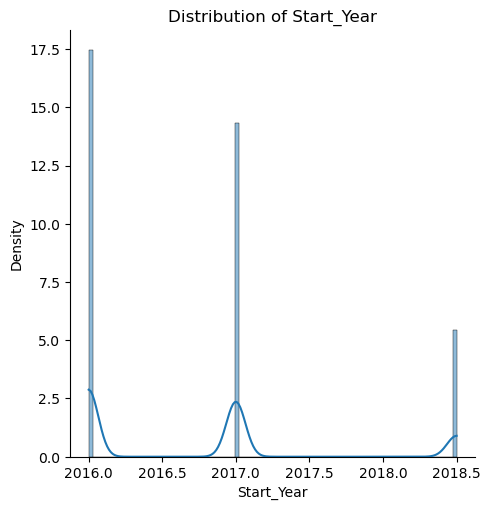

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


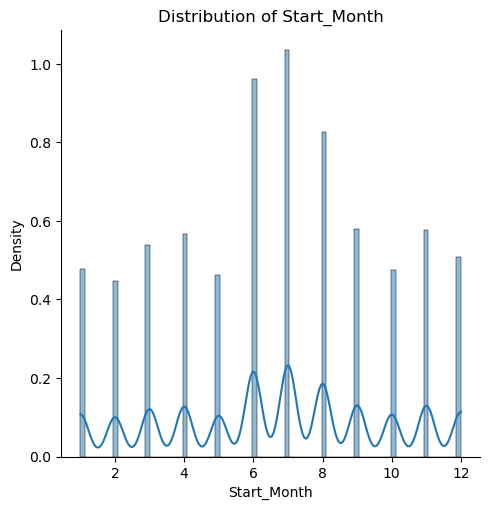

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


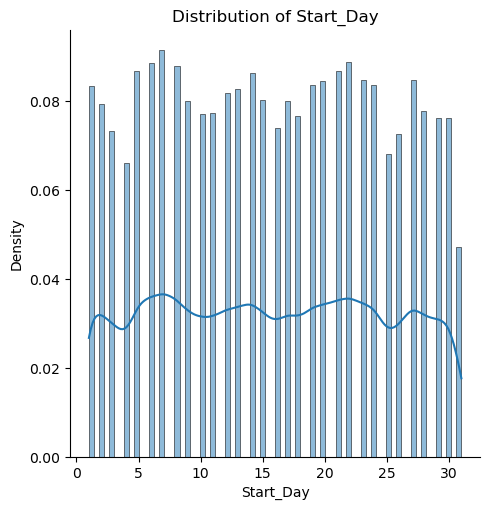

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


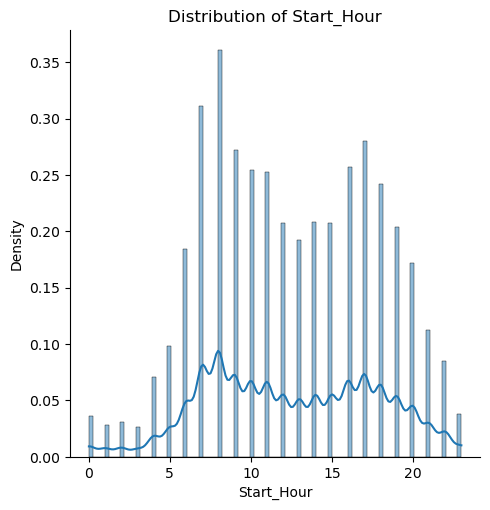

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


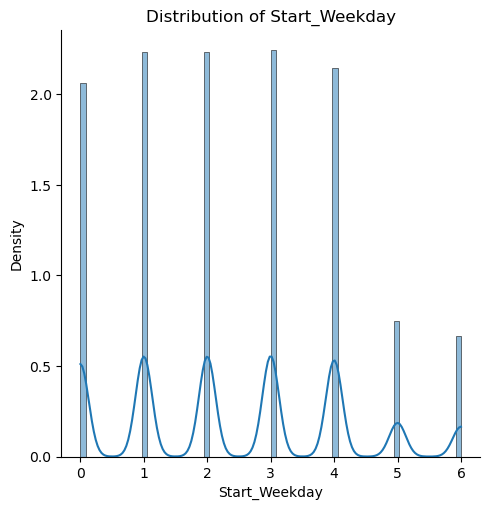

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


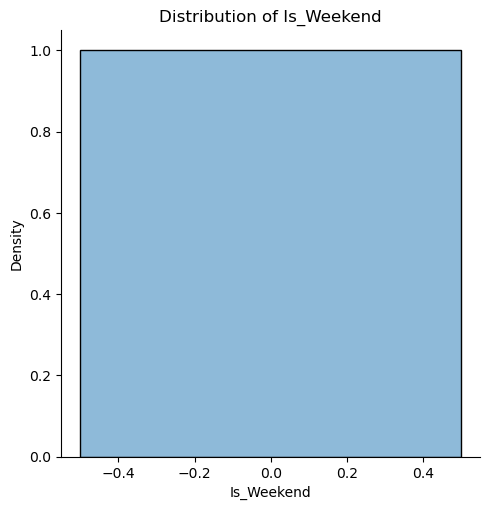

In [38]:
for column in df.columns:
    sns.displot(df[column], kde=True, stat='density')
    plt.title(f'Distribution of {column}')
    plt.show()  # Show the plot for each column

## Categorizing data into different cols

In [13]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()  # Columns with numeric data types
cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()  # Non-numeric columns (categorical)

num_cols.remove('Severity')

print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numerical Columns: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Start_Year', 'Start_Month', 'Start_Day', 'Start_Hour', 'Start_Weekday', 'Is_Weekend']
Categorical Columns: ['Source', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']


# Making a list of null columns

In [14]:
keep_cols = [
    "Temperature(F)",
    "Humidity(%)",
    "Pressure(in)",
    "Visibility(mi)",
    "Wind_Direction",
    "Wind_Speed(mph)",
    "Weather_Condition"
]

# Creating boxplots to identify outliers

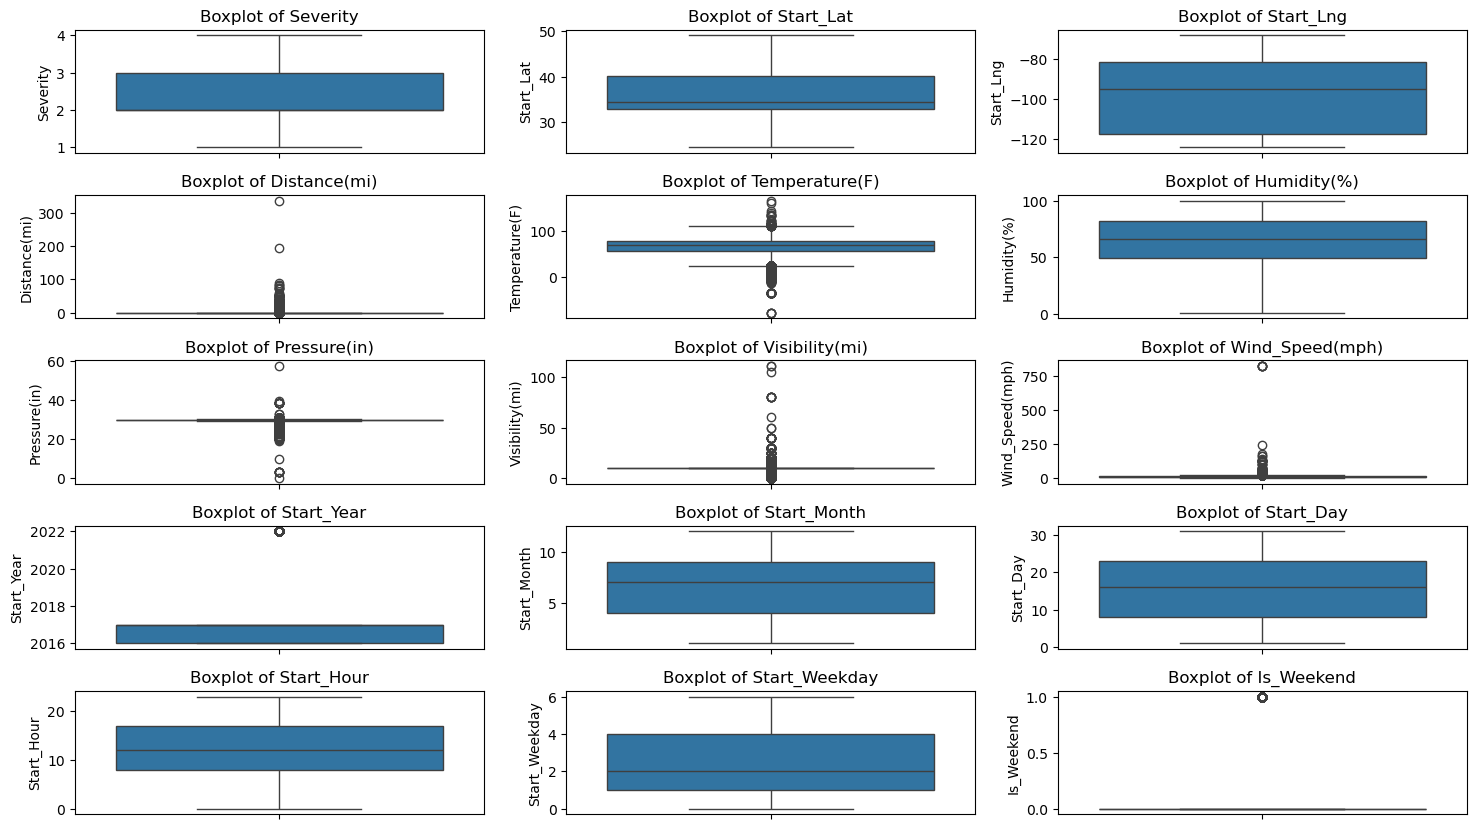

Column: Severity
Number of outliers: 0
--------------------
Column: Start_Lat
Number of outliers: 0
--------------------
Column: Start_Lng
Number of outliers: 0
--------------------
Column: Distance(mi)
Number of outliers: 19096
--------------------
Column: Temperature(F)
Number of outliers: 9411
--------------------
Column: Humidity(%)
Number of outliers: 0
--------------------
Column: Pressure(in)
Number of outliers: 62018
--------------------
Column: Visibility(mi)
Number of outliers: 101092
--------------------
Column: Wind_Speed(mph)
Number of outliers: 7014
--------------------
Column: Start_Year
Number of outliers: 87783
--------------------
Column: Start_Month
Number of outliers: 0
--------------------
Column: Start_Day
Number of outliers: 0
--------------------
Column: Start_Hour
Number of outliers: 0
--------------------
Column: Start_Weekday
Number of outliers: 0
--------------------
Column: Is_Weekend
Number of outliers: 69090
--------------------


In [15]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Box plots for outlier visualization
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# Calculate IQR and identify outliers for each numerical column
outlier_info = {}  # Store outlier information for each column

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    outlier_info[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'num_outliers': len(outliers),
    }

    print(f"Column: {col}")
    print(f"Number of outliers: {len(outliers)}")
    print("-" * 20)

# Handle outliers using IQR method

In [16]:


#remove severity from the numerical cols
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('Severity')
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the bounds
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Creating a pipeline and predicting

### Storing the null categorical and numerical cols

In [17]:
null_int_cols = list(set(keep_cols).intersection(set(num_cols)))
null_cat_cols = list(set(keep_cols).intersection(set(cat_cols)))

null_int_cols , null_cat_cols

(['Visibility(mi)',
  'Pressure(in)',
  'Humidity(%)',
  'Wind_Speed(mph)',
  'Temperature(F)'],
 ['Wind_Direction', 'Weather_Condition'])

# Train-test-split

In [18]:
from sklearn.model_selection import train_test_split
df = df.sample(400000)
x_train , x_test , y_train , y_test = train_test_split(df.drop(columns=['Severity']), df['Severity'] , test_size=0.2 , random_state=42)

# Encoding y columns using label encoder

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test= le.transform(y_test)

## 1) Imputation + Encoder Transformer

In [39]:
# All categorical columns that will go through imputation and OHE
all_cat_cols = null_cat_cols + cat_cols  


imp_enc = ColumnTransformer(
    transformers=[
        ("num_missing", SimpleImputer(strategy="median"), null_int_cols),  
        ("cat_imputer_ohe", Pipeline(steps=[
            ("cat_imputer", SimpleImputer(strategy="most_frequent")),  
            ("ohe_trf", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ]), cat_cols),  
    ],
    remainder='passthrough'
)


## Yeo-johnson Tranformer to Normalize the data

In [23]:
from sklearn.preprocessing import PowerTransformer
yj_trf = PowerTransformer()

## Standard scaler to scale the data

In [24]:
from sklearn.preprocessing import StandardScaler
scaler_trf = ColumnTransformer([
    ("scaler_trf" , StandardScaler() , slice(0,40))
])

## PCA for dimensionality reduction

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)

## defining the pipeline for pre-processing of data

In [27]:
pre_pipe = Pipeline([
    ("preprocessor" , imp_enc),
    ("yj_trf" , yj_trf),
    ("scaler_trf" , scaler_trf),
    ("pca" , pca)
])

In [28]:
x_train_trf = pre_pipe.fit_transform(x_train)

/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/vanshbansal/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [29]:
x_test_trf = pre_pipe.transform(x_test)

In [40]:
from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB

# Training different models

### KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train_trf,y_train)
y_pred = knn.predict(x_test_trf)

accuracy_score(y_test , y_pred)

0.5645875

### logistic regression

In [31]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train_trf,y_train)
y_pred=lr.predict(x_test_trf)
accuracy_score(y_test , y_pred)

0.58015

### Random Forest

In [41]:
rf = RandomForestClassifier()
rf.fit(x_train_trf , y_train)
y_pred = rf.predict(x_test_trf)

accuracy_score(y_pred , y_test)

0.590825

## XGBoost

In [33]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(x_train_trf , y_train)
y_pred = xgb.predict(x_test_trf)
accuracy_score(y_pred , y_test)

0.5936

## Using grid-searchCV for Random forest

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_depth': [10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split a node
    'min_samples_leaf': [2, 4]  # Minimum number of samples required to be at a leaf node
}

# Set up the GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(x_train_trf, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

In [35]:
x_train_trf.shape

(320000, 15)

## Training a neural network

In [36]:
import tensorflow as tf


inputs = tf.keras.Input(shape=(x_test_trf.shape[1],))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

batch_size = 32
epochs = 20

history = model.fit(
    x_train_trf,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 4s 394us/step - accuracy: 0.5814 - loss: 0.7683 - val_accuracy: 0.5868 - val_loss: 0.7493 - learning_rate: 0.0010
Epoch 2/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 3s 372us/step - accuracy: 0.5897 - loss: 0.7480 - val_accuracy: 0.5887 - val_loss: 0.7454 - learning_rate: 0.0010
Epoch 3/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 3s 369us/step - accuracy: 0.5904 - loss: 0.7451 - val_accuracy: 0.5865 - val_loss: 0.7456 - learning_rate: 0.0010
Epoch 4/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 3s 397us/step - accuracy: 0.5898 - loss: 0.7443 - val_accuracy: 0.5864 - val_loss: 0.7436 - learning_rate: 0.0010
Epoch 5/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 3s 370us/step - accuracy: 0.5904 - loss: 0.7426 - val_accuracy: 0.5883 - val_loss: 0.7429 - learning_rate: 0.0010
Epoch 6/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 3s 369us/step - accuracy: 0.5903 - loss: 0.7426 - val_accuracy: 0.5897 - val_loss: 0.7429 - learning_rate: 0.0010
Epoch 7/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 3s 369us/step - accura

In [37]:
print("Test Accuracy:", model.evaluate(x_test_trf, y_test, verbose=0)[1])

Test Accuracy: 0.5873500108718872
